# Импорт библиотек

In [40]:
import json
import re

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame


# Объединим все данные в один датасет

In [6]:
def open_json(input_file: str) -> dict:
    with open(input_file) as json_file:
        data = json.load(json_file)
    return data

In [14]:
def json_to_csv_lp(json_data: dict) -> DataFrame:
    rows = []
    for category, works in json_data.items():
        for author, work_data in works.items():
            rows.append({
                "title": work_data.get("title", ""),
                "text": work_data.get("text", "")
            })

    df = pd.DataFrame(rows)
    return df

In [15]:
def json_to_csv(json_data: dict) -> DataFrame:
    rows = []
    for title, text in json_data.items():
        rows.append({
            "title": title,
            "text": text
        })

    df = pd.DataFrame(rows)
    return df

clean_data

In [16]:
briefly = open_json("../data/temp_data/json/briefly.json")
litprichal = open_json("../data/temp_data/json/data_litprichal.json")
proza_ru = open_json("../data/temp_data/json/data_proza_ru.json")
litres = open_json("../data/temp_data/json/litres.json")

In [17]:
briefly = json_to_csv(briefly)
litprichal = json_to_csv_lp(litprichal)
proza_ru = json_to_csv_lp(proza_ru)
litres = json_to_csv(litres)

In [87]:
data = pd.concat([briefly, litprichal, proza_ru, litres], ignore_index=True)

In [88]:
data

,title,text
0,"Житие протопопа Аввакума, им самим написанное",Протопоп Аввакум написал житие по благословени...
1,Переписка Андрея Курбского с Иваном Грозным,Князь Андрей Курбский — один из лучших воевод ...
2,Житие Сергия Радонежского,"Преподобный Сергий родился в Тверской земле, в..."
3,Повесть о Петре и Февронии Муромских,В городе Муроме правил князь Павел. К его жене...
4,Моление Даниила Заточника,"«Моление», как и многие другие произведения др..."
...,...,...
32787,Мифические монстры и места их обитания,В этой увлекательной и познавательной книге ав...
32788,Легенда о страшном Змее и наглой девице,Всё пошло не так: девица явилась сама в змеево...
32789,Сказки темной Руси,"Гуляли, значит, по матушке Руси три статных мо..."
32790,"Сезам, откройся!!!","«– Вы начинаете стареть, Иоганн, – ворчливо ск..."


In [89]:
len(briefly) + len(litprichal) + len(proza_ru) + len(litres) - len(data)

0

Никакие данные не потерялись

# Работа с данными

In [90]:
data = data.apply(lambda col: col.str.lower().str.strip())

## Почистим данные от всего лишнего

### Удалим лишние символы

Удалим пропущенные значения

In [91]:
data.isna().sum()

title      0
text     707
dtype: int64

In [92]:
data = data.dropna().reset_index(drop=True)

In [93]:
def clean_text(text):
    """Удаляет лишние символы из текста"""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [94]:
data.text = data.text.apply(clean_text)

## Уберем из названий нумерацию (том, эпизод и т.п.)

In [95]:
def remove_complex_volume_numbers(title):
    """
    Удаляет сложные формы нумерации: (139 эпизод 2 том 2.)
    """
    if pd.isna(title):
        return title

    title_str = str(title)

    patterns = [
        r'\(?\s*\d+\s+(?:эпизод|серия|глава|часть)\s+\d+\s+(?:том|книга|т\.)\s*\d*\s*\.?\)?',
        r'\(?\s*\d+\s+(?:том|книга|т\.)\s+\d+\s+(?:эпизод|серия|глава|часть)\s*\d*\s*\.?\)?',

        r'\b\d+\s+\d+\s+(?:том|часть|книга|эпизод|серия)\b',
        r'\b(?:том|часть|книга|эпизод|серия)\s+\d+\s+\d+\b',

        r'\b\d+[-\.,]\s*\d+\s+(?:том|часть|книга)',
        r'\b(?:том|часть|книга)\s+\d+[-\.,]\s*\d+\b',
    ]

    cleaned_title = title_str
    for pattern in patterns:
        cleaned_title = re.sub(pattern, '', cleaned_title, flags=re.IGNORECASE)

    return cleaned_title

def clean_title_completely(title):
    """
    Полная очистка названия от всех видов нумерации
    """
    if pd.isna(title):
        return title

    cleaned = remove_complex_volume_numbers(title)

    basic_patterns = [
        r'\s*(?:том|часть|книга|т\.|vol\.?|эпизод|серия|глава|выпуск)\s*[ivxlcdm0-9]+',
        r'\s*[ivxlcdm0-9]+\s*(?:том|часть|книга|т\.|vol\.?|эпизод|серия|глава|выпуск)',
        r'\s*\d+[-\.,]?\s*(?:том|часть|книга)',
        r'\s*(?:том|часть|книга)[-\.,]?\s*\d+',
    ]

    for pattern in basic_patterns:
        cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)

    cleaned = re.sub(r'\([^)]*\d+[^)]*\)', '', cleaned)
    cleaned = re.sub(r'\s+\d+\s*\.?$', '', cleaned)
    cleaned = re.sub(r'^\d+\s+', '', cleaned)

    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+$', '', cleaned)
    cleaned = re.sub(r'[\(\)\[\]]', '', cleaned)
    cleaned = re.sub(r'[,\-\.:;]+$', '', cleaned)

    return cleaned


In [96]:
data["cleaned_title"] = data.title.apply(clean_title_completely)

In [97]:
changed_count = (data.title != data.cleaned_title).sum()
print(f"Изменено названий: {changed_count} из {len(data)}")

Изменено названий: 6989 из 32085


In [98]:
data.describe()

,title,text,cleaned_title
count,32085,32085,32085
unique,29841,30655,28570
top,"просыпаюсь, а ты рядом! дню семьи",,энцикловикипедия. имена
freq,38,545,38


почему то есть полностью пустые тексты

In [99]:
data.isna().sum()

title            0
text             0
cleaned_title    0
dtype: int64

In [100]:
data = data[data.text != ""].reset_index(drop=True)
data = data[data.title != ""].reset_index(drop=True)

In [101]:
data.describe()

,title,text,cleaned_title
count,31540,31540,31540
unique,29367,30654,28108
top,скрытая опасность,описание отсутствует,энцикловикипедия. имена
freq,38,124,38


есть пустые тексты с заглушкой «описание отсутствует», удалим их

In [102]:
data = data[data.text != "описание отсутствует"].reset_index(drop=True)

In [103]:
data.describe()

,title,text,cleaned_title
count,31416,31416,31416
unique,29267,30653,28015
top,энцикловикипедия. имена,постоянное место публикации сборник о любви вс...,"просыпаюсь, а ты рядом! дню семьи"
freq,38,38,38


In [105]:
data.cleaned_title.value_counts().head(20)

cleaned_title
просыпаюсь, а ты рядом! дню семьи                     38
энцикловикипедия. имена                               38
корнеслов. история слов                               38
энцикловикипедия. топонимы                            38
скрытая опасность                                     38
из жизни графомана                                    38
латырь-камень бел-горюч... сказка?                    38
три поколения швондеров и мы выбираем                 36
красноярск глазами московского туриста                34
                                                      28
мысли по поводу                                       25
классика зарубежного рассказа №                       25
***                                                   20
выкладка                                              20
наследник ссср - фрагмент                             20
сергей степанов. постлюбовь. новый роман              20
классика русского рассказа №                          18
содержание. трудн

Заметим, что в названиях часто встречаются пустые названия или момстоящие только из символов. Также есть шумовые №

In [111]:
data = data[data.cleaned_title.str.strip() != ""]
noise_titles = ["***"]
data = data[~data.cleaned_title.isin(noise_titles)].reset_index(drop=True)

print(data.cleaned_title.value_counts().head(20))
print(f"Всего примеров после очистки: {len(data)}")

cleaned_title
латырь-камень бел-горюч... сказка?                    38
из жизни графомана                                    38
корнеслов. история слов                               38
энцикловикипедия. имена                               38
просыпаюсь, а ты рядом! дню семьи                     38
энцикловикипедия. топонимы                            38
скрытая опасность                                     38
три поколения швондеров и мы выбираем                 36
красноярск глазами московского туриста                34
классика зарубежного рассказа                         26
мысли по поводу                                       25
наследник ссср - фрагмент                             20
выкладка                                              20
сергей степанов. постлюбовь. новый роман              20
тихий дон                                             18
классика русского рассказа                            18
содержание. трудные места библии. жесток ли ветхий    18
самая длинная ист

In [108]:
data.cleaned_title = data.cleaned_title.str.replace('№', '', regex=False).str.strip()

print(data.cleaned_title.value_counts().head(20))

cleaned_title
латырь-камень бел-горюч... сказка?                    38
из жизни графомана                                    38
корнеслов. история слов                               38
энцикловикипедия. имена                               38
просыпаюсь, а ты рядом! дню семьи                     38
энцикловикипедия. топонимы                            38
скрытая опасность                                     38
три поколения швондеров и мы выбираем                 36
красноярск глазами московского туриста                34
классика зарубежного рассказа                         26
мысли по поводу                                       25
наследник ссср - фрагмент                             20
выкладка                                              20
сергей степанов. постлюбовь. новый роман              20
тихий дон                                             18
классика русского рассказа                            18
содержание. трудные места библии. жесток ли ветхий    18
самая длинная ист

## Посмотрим на дубликаты

In [109]:
data.duplicated().sum()

np.int64(429)

In [110]:
data.text.duplicated().sum(), data.title.duplicated().sum()

(np.int64(763), np.int64(2127))

Заметим, что есть дубликаты в названиях, но это нормально, так как парсились разные сайты, на которых могли быть одни и те же произведения. Такое можно оставить.

Но есть дубликаты в тексте, причем большинство из них такие, что текст одинаковый, а названия разные. Такое нужно удалять, это создаст лишний шум для модели.

In [112]:
data = data[~data.text.duplicated(keep=False)].reset_index(drop=True)

In [113]:
data.duplicated().sum()

np.int64(0)

In [114]:
data.describe()

,title,text,cleaned_title
count,30353,30353,30353
unique,28695,30353,27623
top,любовь,протопоп аввакум написал житие по благословени...,классика зарубежного рассказа
freq,12,1,26


In [115]:
data.drop(columns=["title"], inplace=True)

In [116]:
data.rename(columns={"cleaned_title": "title"}, inplace=True)

In [117]:
data.to_csv("../data/temp_data/all_data_cleaned.csv", index=False)

# Анализ длины слов в названиях

In [118]:
title_counts = data.title.value_counts()
title_counts.head(10)

title
классика зарубежного рассказа               26
наследник ссср - фрагмент                   20
выкладка                                    20
сергей степанов. постлюбовь. новый роман    20
тихий дон                                   18
классика русского рассказа                  18
самая длинная история на свете              17
встреча                                     14
alex zirk. collection of music. a. z        12
печалька и ее дядя                          12
Name: count, dtype: int64

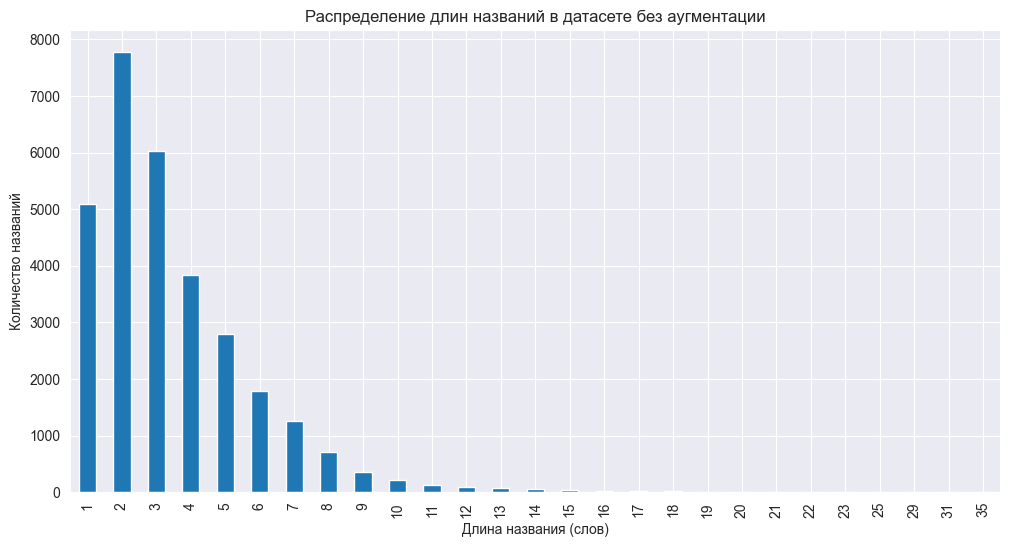

In [119]:
data["title_len"] = data.title.apply(lambda x: len(str(x).split()))

length_counts = data.groupby('title_len').size()

plt.figure(figsize=(12,6))
length_counts.plot(kind='bar')
plt.xlabel("Длина названия (слов)")
plt.ylabel("Количество названий")
plt.title("Распределение длин названий в датасете без аугментации")
plt.show()

Заметно, что есть названия с большим количеством слов. Это внесет в модель шум, поэтому стоит удалить их.

In [121]:
data.describe(include="O")

,text,title
count,30353,30353
unique,30353,27623
top,протопоп аввакум написал житие по благословени...,классика зарубежного рассказа
freq,1,26


In [122]:
data = data[data.title_len <= 10].reset_index(drop=True)

In [123]:
data.describe(include="O")

,text,title
count,29869,29869
unique,29869,27140
top,протопоп аввакум написал житие по благословени...,классика зарубежного рассказа
freq,1,26


In [125]:
data['text_len'] = data.text.str.split().apply(len)

In [126]:
print("Всего примеров:", len(data))
print("Уникальные заголовки:", data.title.nunique())
print("Средняя длина текста:", data.text_len.mean())
print("Средняя длина заголовка:", data.title_len.mean())

Всего примеров: 29869
Уникальные заголовки: 27140
Средняя длина текста: 1905.6633298737822
Средняя длина заголовка: 3.306002879239345


In [127]:
data.to_csv("../data/all_data.csv", index=False)